## Import lib

In [2]:
import json
from openai import OpenAI
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pirayan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Transcribe

In [6]:
client = OpenAI()

audio_file= open("../audio/marry_you.mp3", "rb")
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=audio_file,
    response_format="verbose_json",
    timestamp_granularities=["word"],
)

print(transcription.words)

[TranscriptionWord(end=11.899999618530273, start=10.739999771118164, word='🎵'), TranscriptionWord(end=13.0600004196167, start=11.899999618530273, word="It's"), TranscriptionWord(end=13.260000228881836, start=13.0600004196167, word='a'), TranscriptionWord(end=13.699999809265137, start=13.260000228881836, word='beautiful'), TranscriptionWord(end=14.779999732971191, start=13.699999809265137, word='night'), TranscriptionWord(end=15.34000015258789, start=14.779999732971191, word="we're"), TranscriptionWord(end=15.600000381469727, start=15.34000015258789, word='looking'), TranscriptionWord(end=16.15999984741211, start=15.600000381469727, word='for'), TranscriptionWord(end=16.479999542236328, start=16.15999984741211, word='something'), TranscriptionWord(end=16.920000076293945, start=16.479999542236328, word='dumb'), TranscriptionWord(end=17.31999969482422, start=16.920000076293945, word='to'), TranscriptionWord(end=18.059999465942383, start=17.31999969482422, word='do'), TranscriptionWord(end

## Some EDA On the data

/Users/pirayan/Work/university/TimeSeriesDataMining/Time-Series-Midterm/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


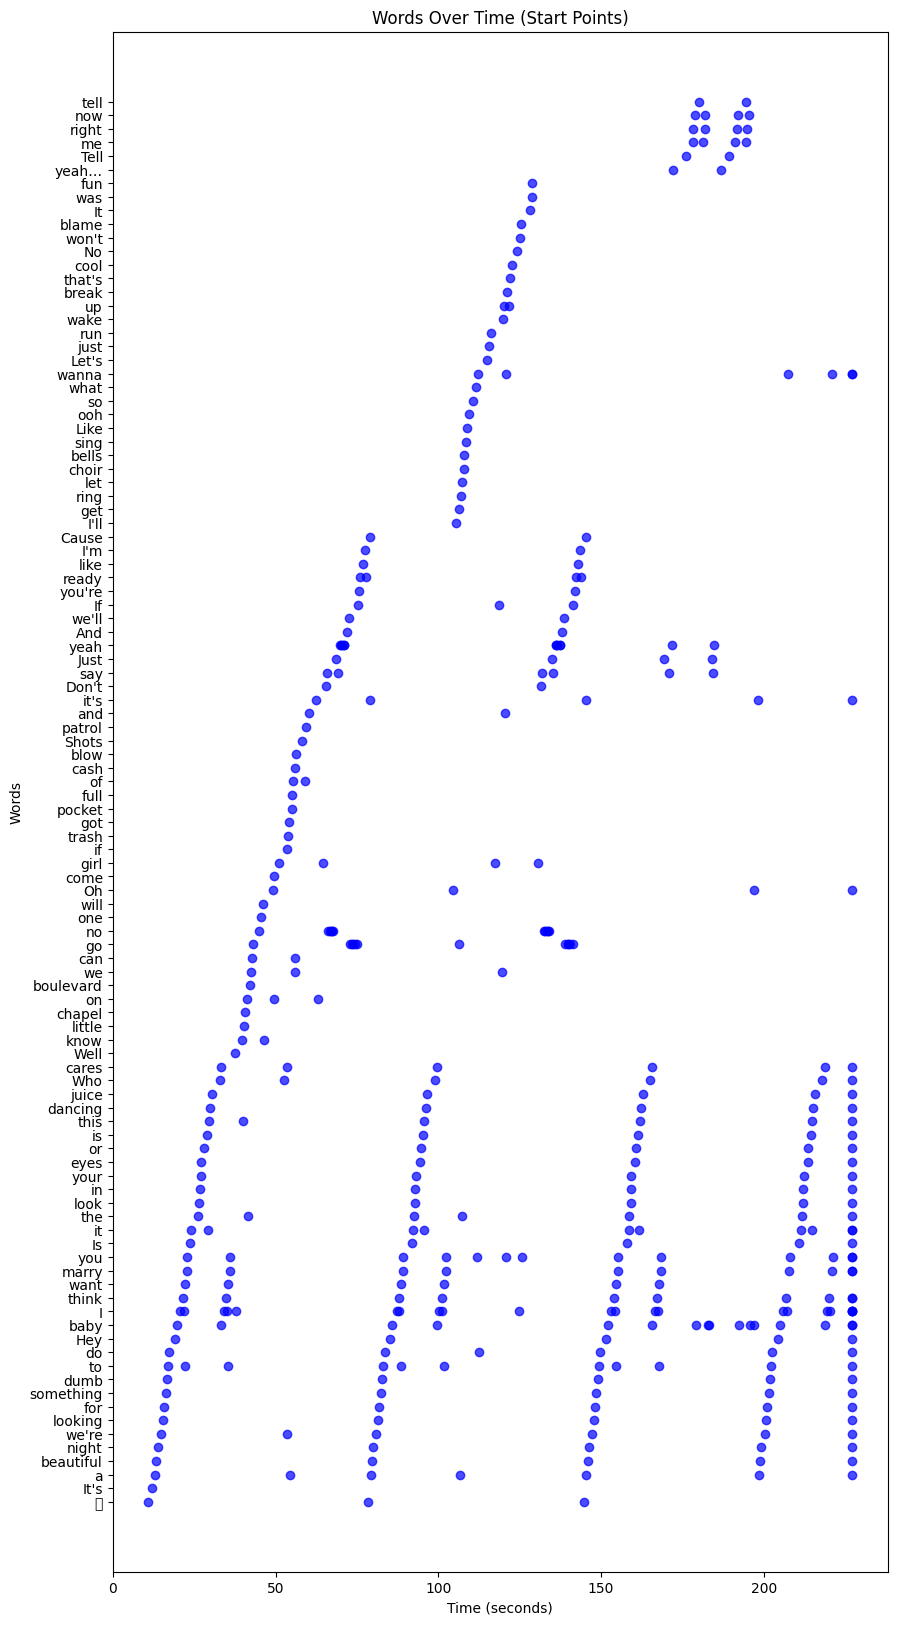

In [7]:
import matplotlib.pyplot as plt

# Extract words, start, and end times
words = [w.word for w in transcription.words]
start_times = [w.start for w in transcription.words]
end_times = [w.end for w in transcription.words]

fig, ax = plt.subplots(figsize=(10,20))
ax.scatter(start_times, words, color="blue", alpha=0.7)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Words")
ax.set_title("Words Over Time (Start Points)")
plt.show()

In [ ]:
def collect_uppercase_sentences(transcription):
    uppercase_sentences = []
    current_sentence = []
    sentence_start_time = None
    last_end_time = None  # Track the last valid end time

    for idx, word_data in enumerate(transcription.words):
        word = word_data.word
        start_time = word_data.start
        end_time = word_data.end

        # If a valid end_time exists, update last_end_time
        if end_time is not None:
            last_end_time = end_time

        # If the word starts with an uppercase letter (ignoring "I"), start a new sentence
        if word[0].isupper() and word != "I":
            # If there's an existing sentence, save it first
            if current_sentence and sentence_start_time is not None:
                full_sentence = " ".join(current_sentence)
                uppercase_sentences.append((sentence_start_time, last_end_time, full_sentence))

            # Start a new sentence
            current_sentence = [word]
            sentence_start_time = start_time
        else:
            # Continue adding words to the current sentence
            current_sentence.append(word)

    # Add the last sentence if valid
    if current_sentence and sentence_start_time is not None:
        full_sentence = " ".join(current_sentence)
        uppercase_sentences.append((sentence_start_time, last_end_time, full_sentence))

    return uppercase_sentences

uppercase_sentences_list = collect_uppercase_sentences(transcription)

# Print collected uppercase sentences with timestamps
for start_time, end_time, sentence in uppercase_sentences_list:
    start_display = f"{start_time:.2f}s" if start_time is not None else "Unknown"
    end_display = f"{end_time:.2f}s" if end_time is not None else "Unknown"
    print(f"[{start_display} - {end_display}] {sentence}")

[11.90s - 19.64s] It's a beautiful night we're looking for something dumb to do
[19.04s - 23.92s] Hey baby I think I want to marry you
[23.78s - 33.06s] Is it the look in your eyes or is it this dancing juice
[32.92s - 37.72s] Who cares baby I think I want to marry you
[37.50s - 49.46s] Well I know this little chapel on the boulevard we can go no one will know
[49.16s - 53.38s] Oh come on girl
[52.72s - 58.98s] Who cares if we're trash got a pocket full of cash we can blow
[58.14s - 65.78s] Shots of patrol and it's on girl
[65.40s - 69.14s] Don't say no no no no no
[68.70s - 72.48s] Just say yeah yeah yeah yeah yeah
[71.86s - 75.76s] And we'll go go go go go
[75.18s - 77.74s] If you're ready like
[77.46s - 79.04s] I'm ready 🎵
[79.04s - 85.86s] Cause it's a beautiful night we're looking for something dumb to do
[85.06s - 92.36s] Hey baby I think I want to marry you
[91.88s - 99.54s] Is it the look in your eyes or is it this dancing juice
[98.84s - 105.44s] Who cares baby I think I want 

## Segmenting the words

In [8]:
TIME_INTERVAL = 10
X_AXIS_INTERVAL = 30
sentiments = []
timestamps = []

In [9]:
segments = {}
word_timestamps = []

for word_data in transcription.words:
    start_time = word_data.start
    word = word_data.word
    word_timestamps.append((start_time, word))

    segment_index = int(start_time // TIME_INTERVAL)

    if segment_index not in segments:
        segments[segment_index] = []

    segments[segment_index].append(word)

print(f"Total segments created: {len(segments)}")

Total segments created: 22


## Get the sentiment score from NLTK(VADER)

In [10]:
sia = SentimentIntensityAnalyzer()

for segment_index in sorted(segments.keys()):
    text = " ".join(segments[segment_index])
    sentiment_score = sia.polarity_scores(text)['compound']  # Get sentiment score

    timestamps.append(segment_index * TIME_INTERVAL)
    sentiments.append(sentiment_score)

In [11]:
average_sentiment = sum(sentiments) / len(sentiments)

In [ ]:
section_changes = [word_data.start for word_data in transcription.words if word_data.word == "🎵"]

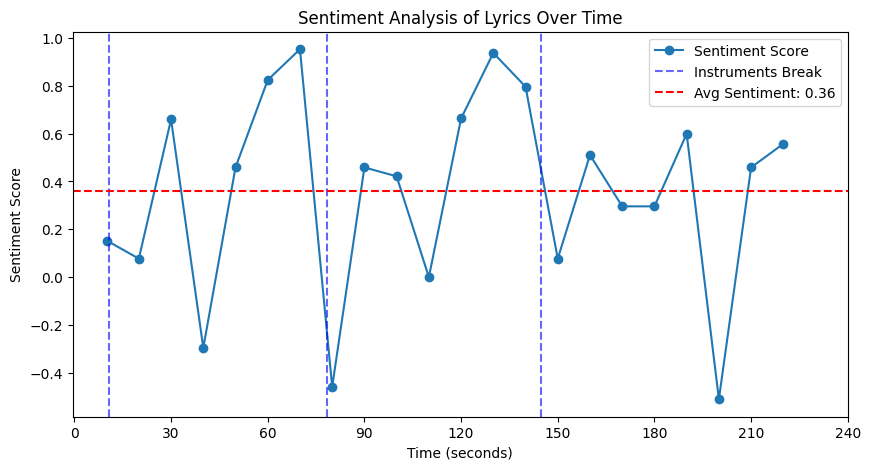

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(timestamps, sentiments, marker='o', linestyle='-', label="Sentiment Score")

for transition_time in section_changes:
    plt.axvline(transition_time, color='blue', linestyle='--', alpha=0.6, label="Instruments Break" if transition_time == section_changes[0] else "")

plt.xlabel("Time (seconds)")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis of Lyrics Over Time")
plt.axhline(average_sentiment, color='red', linestyle='--', label=f"Avg Sentiment: {average_sentiment:.2f}")
plt.xticks(np.arange(0, max(timestamps) + X_AXIS_INTERVAL, X_AXIS_INTERVAL))
plt.legend()
plt.show()